In [ ]:
!pip install datasets scikit-learn --quiet
!pip install -U transformers --quiet

In [ ]:
# ✅ Libraries
import os, re, torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import AdamW
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [ ]:
# ✅ Normalize
def normalize_phrases(text):
    text = re.sub(r'\bblack\s*lives\s*matter\b', 'black-lives-matter', text, flags=re.IGNORECASE)
    text = re.sub(r'\ball\s*lives\s*matter\b', 'all-lives-matter', text, flags=re.IGNORECASE)
    return text

In [ ]:
# ✅ Load + Balance
def load_data(subtitle_path, annotation_path):
    data = []
    skipped = 0
    for platform in ['instagram', 'tiktok', 'youtube']:
        for label_folder in ['alm', 'blm']:
            sub_dir = os.path.join(subtitle_path, platform, label_folder)
            ann_dir = os.path.join(annotation_path, platform, label_folder)
            print(ann_dir)
            if not os.path.exists(sub_dir): continue
            for fname in os.listdir(sub_dir):
                if not fname.endswith('.txt'): continue
                print(fname)
                txt_path = os.path.join(sub_dir, fname)
                csv_path = os.path.join(ann_dir, fname.replace('.txt', '.csv'))
                if not os.path.exists(csv_path) or os.stat(csv_path).st_size == 0:
                    skipped += 1
                    continue
                try:
                    with open(txt_path, 'r') as f:
                        text = normalize_phrases(f.read().strip())
                    ann_df = pd.read_csv(csv_path)
                    ann_df.columns = [c.strip().lower() for c in ann_df.columns]
                    if 'word' not in ann_df or 'emotion' not in ann_df: continue
                    ann_df['word'] = ann_df['word'].astype(str).apply(normalize_phrases)
                    for word, emotion in zip(ann_df['word'], ann_df['emotion']):
                        data.append({
                            'text': word,
                            'label': 1 if emotion.lower() == 'positive' else 0
                        })
                except: skipped += 1
    df = pd.DataFrame(data)
    print(f"✅ Loaded {len(df)} samples | Skipped {skipped} files")
    print(df['label'].value_counts())

    # Oversampling
    df_majority = df[df.label == df.label.mode()[0]]
    df_minority = df[df.label != df.label.mode()[0]]
    df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
    df_balanced = pd.concat([df_majority, df_minority_upsampled]).sample(frac=1).reset_index(drop=True)
    print("✅ Balanced class distribution:\n", df_balanced['label'].value_counts())
    return df_balanced

In [ ]:
# ✅ Dataset class
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=32):
        self.tokenizer = tokenizer
        self.data = df
        self.max_len = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        input_enc = self.tokenizer(
            row['input_text'], max_length=self.max_len, truncation=True, padding="max_length", return_tensors="pt"
        )
        target_enc = self.tokenizer(
            row['target_text'], max_length=5, truncation=True, padding="max_length", return_tensors="pt"
        )
        labels = target_enc["input_ids"]
        labels[labels == tokenizer.pad_token_id] = -100

        return {
            "input_ids": input_enc["input_ids"].squeeze(),
            "attention_mask": input_enc["attention_mask"].squeeze(),
            "labels": labels.squeeze(),
            "label_binary": row["label"]
        }

In [ ]:
# ✅ Load everything
subtitle_base = '/content/drive/MyDrive/sentiment/new_csv/subtitles'
annotation_base = '/content/drive/MyDrive/sentiment/new_csv/annotation/subtitles'
df = load_data(subtitle_base, annotation_base)
df = df.dropna().reset_index(drop=True)

# ✅ Setup
MODEL_ID = "Anshul99/ALM_BLM_Narratives_Stance_using"
BATCH_SIZE = 8
EPOCHS = 10
LR = 3e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = T5Tokenizer.from_pretrained(MODEL_ID)
model = T5ForConditionalGeneration.from_pretrained(MODEL_ID).to(DEVICE)
dataset = SentimentDataset(df, tokenizer)

/content/drive/MyDrive/sentiment/new_csv/annotation/subtitles/instagram/alm
vid2_ig_1.txt
vid2_ig_2.txt
vid2_ig_3.txt
vid2_ig_4.txt
vid2_ig_5.txt
vid2_ig_6.txt
vid2_ig_7.txt
vid5_ig_1.txt
vid5_ig_2.txt
vid8_ig_1.txt
vid8_ig_2.txt
/content/drive/MyDrive/sentiment/new_csv/annotation/subtitles/instagram/blm
vid11_ig_1.txt
vid11_ig_2.txt
vid12_ig_1.txt
vid12_ig_2.txt
vid13_ig_1.txt
vid13_ig_2.txt
vid13_ig_3.txt
vid15_ig_2.txt
vid15_ig_3.txt
vid18_ig_1.txt
vid15_ig_1.txt
/content/drive/MyDrive/sentiment/new_csv/annotation/subtitles/tiktok/alm
vid1_tiktok_1.txt
vid2_tiktok_1.txt
vid3_tiktok_1.txt
vid4_tiktok_1.txt
vid5_tiktok_1.txt
vid6_tiktok_1.txt
vid8_tiktok_1.txt
vid9_tiktok_1.txt
vid9_tiktok_2.txt
vid10_tiktok_1.txt
vid10_tiktok_2.txt
/content/drive/MyDrive/sentiment/new_csv/annotation/subtitles/tiktok/blm
vid11_tiktok_1.txt
vid11_tiktok_2.txt
vid12_tiktok_1.txt
vid14_tiktok_3.txt
vid17_tiktok_1.txt
vid18_tiktok_1.txt
vid18_tiktok_2.txt
vid20_tiktok_1.txt
vid14_tiktok_1.txt
vid14_tiktok

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
print(model)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=1024, out_features=2816, bias=False)
              (wi_1): Linear(in_features=1024, out_features=2816, bias=False)
       

In [ ]:
# Oversampling
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# 1. Load and oversample the data
df = load_data(subtitle_base, annotation_base)

# 2. Add input-target columns for T5
df['input_text'] = df['text'].apply(lambda x: f"classify sentiment: {x}")
df['target_text'] = df['label'].map({1: "positive", 0: "negative"})

# 3. Oversample the minority class
df_majority = df[df['label'] == df['label'].mode()[0]]
df_minority = df[df['label'] != df['label'].mode()[0]]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

df_balanced = pd.concat([df_majority, df_minority_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

print("\n✅ Dataset Balanced Using Oversampling:")
print(df_balanced['label'].value_counts())

# 4. Perform train-val-test split (60-20-20)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df_balanced[['input_text', 'target_text']],
    df_balanced['label'],
    test_size=0.4,
    stratify=df_balanced['label'],
    random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

# 5. Reconstruct final DataFrames
train_df = train_texts.copy()
train_df['label'] = train_labels

val_df = val_texts.copy()
val_df['label'] = val_labels

test_df = test_texts.copy()
test_df['label'] = test_labels


/content/drive/MyDrive/sentiment/new_csv/annotation/subtitles/instagram/alm
vid2_ig_1.txt
vid2_ig_2.txt
vid2_ig_3.txt
vid2_ig_4.txt
vid2_ig_5.txt
vid2_ig_6.txt
vid2_ig_7.txt
vid5_ig_1.txt
vid5_ig_2.txt
vid8_ig_1.txt
vid8_ig_2.txt
/content/drive/MyDrive/sentiment/new_csv/annotation/subtitles/instagram/blm
vid11_ig_1.txt
vid11_ig_2.txt
vid12_ig_1.txt
vid12_ig_2.txt
vid13_ig_1.txt
vid13_ig_2.txt
vid13_ig_3.txt
vid15_ig_2.txt
vid15_ig_3.txt
vid18_ig_1.txt
vid15_ig_1.txt
/content/drive/MyDrive/sentiment/new_csv/annotation/subtitles/tiktok/alm
vid1_tiktok_1.txt
vid2_tiktok_1.txt
vid3_tiktok_1.txt
vid4_tiktok_1.txt
vid5_tiktok_1.txt
vid6_tiktok_1.txt
vid8_tiktok_1.txt
vid9_tiktok_1.txt
vid9_tiktok_2.txt
vid10_tiktok_1.txt
vid10_tiktok_2.txt
/content/drive/MyDrive/sentiment/new_csv/annotation/subtitles/tiktok/blm
vid11_tiktok_1.txt
vid11_tiktok_2.txt
vid12_tiktok_1.txt
vid14_tiktok_3.txt
vid17_tiktok_1.txt
vid18_tiktok_1.txt
vid18_tiktok_2.txt
vid20_tiktok_1.txt
vid14_tiktok_1.txt
vid14_tiktok

In [ ]:
# ✅ Split: 60-20-20
# Dataset class instance
train_dataset = SentimentDataset(train_df, tokenizer)
val_dataset = SentimentDataset(val_df, tokenizer)
test_dataset = SentimentDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

optimizer = AdamW(model.parameters(), lr=LR)
train_losses = []

In [ ]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

2478
826
826
310
104
104


In [ ]:
# ✅ Train Loop with Metrics
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # ✅ Validation metrics
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)
            binary_targets = batch["label_binary"]

            output_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=5)
            decoded_preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
            decoded_preds = [1 if x.strip().lower() == "positive" else 0 for x in decoded_preds]
            preds.extend(decoded_preds)
            targets.extend(binary_targets)

    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds)
    try:
        auc = roc_auc_score(targets, preds)
    except:
        auc = 0.0

    print(f"✅ Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | Acc: {acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


✅ Epoch 1/10 | Loss: 0.2825 | Acc: 0.7579 | F1: 0.7732 | AUC: 0.7579
✅ Epoch 2/10 | Loss: 0.2446 | Acc: 0.7421 | F1: 0.7361 | AUC: 0.7421
✅ Epoch 3/10 | Loss: 0.2256 | Acc: 0.7651 | F1: 0.7868 | AUC: 0.7651
✅ Epoch 4/10 | Loss: 0.2051 | Acc: 0.7785 | F1: 0.7875 | AUC: 0.7785
✅ Epoch 5/10 | Loss: 0.1917 | Acc: 0.7760 | F1: 0.7933 | AUC: 0.7760
✅ Epoch 6/10 | Loss: 0.1818 | Acc: 0.7591 | F1: 0.7399 | AUC: 0.7591
✅ Epoch 7/10 | Loss: 0.1677 | Acc: 0.7906 | F1: 0.7938 | AUC: 0.7906
✅ Epoch 8/10 | Loss: 0.1615 | Acc: 0.7821 | F1: 0.7857 | AUC: 0.7821
✅ Epoch 9/10 | Loss: 0.1562 | Acc: 0.7869 | F1: 0.7880 | AUC: 0.7869
✅ Epoch 10/10 | Loss: 0.1535 | Acc: 0.7918 | F1: 0.8009 | AUC: 0.7918



📊 Final Test Set Results:
Accuracy: 0.7433 | F1: 0.7618 | AUC: 0.7433


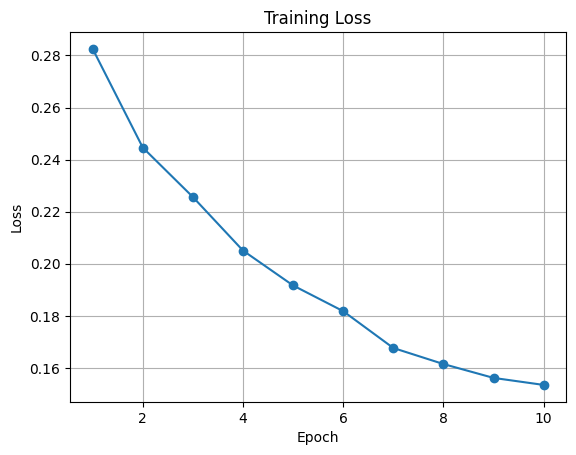

In [ ]:
# ✅ Final Evaluation on Test Set
model.eval()
final_preds, final_targets = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        binary_targets = batch["label_binary"]

        output_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=5)
        decoded_preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
        decoded_preds = [1 if x.strip().lower() == "positive" else 0 for x in decoded_preds]
        final_preds.extend(decoded_preds)
        final_targets.extend(binary_targets)

final_acc = accuracy_score(final_targets, final_preds)
final_f1 = f1_score(final_targets, final_preds)
final_auc = roc_auc_score(final_targets, final_preds)
print(f"\n📊 Final Test Set Results:\nAccuracy: {final_acc:.4f} | F1: {final_f1:.4f} | AUC: {final_auc:.4f}")

# ✅ Plot Loss
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

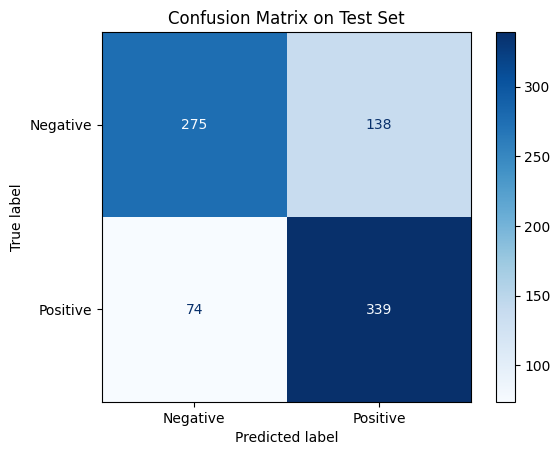

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ✅ Confusion Matrix
cm = confusion_matrix(final_targets, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Test Set")
plt.grid(False)
plt.show()

# Model Save

In [ ]:
os.makedirs("/content/drive/MyDrive/final_models_saved/MaskedABSA", exist_ok=True)

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/final_models_saved/MaskedABSA/maskedABSA_finetuned2.pth")